In [1]:
import pandas as pd
import matplotlib 
from gui.utils import *

fleet = ['VQ-BGU', 'VQ-BDU']
y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).query('egtm > 0 and oat_peak > -100')
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).query('egtm > 0 and oat_peak > -100')

data = pd.concat([bgu, bdu]).sort_values('reportts').drop(columns=['file_path', 'dep', 'arr'])


In [2]:
def correct(data, alpha_2 = 0.84):
  datak = data
  alpha = 0.5

  theta = (data['t2'] + 273.16) / 288.16
  theta_peak = (data['tat_peak'] + 273.16) / (288.16 * (1.0 + 0.2 * data['mn_peak'] ** 2))
  delta = data['p2e'] / 29.92

  datak['nfk'] = data['nf'] / (theta ** alpha)
  datak['n1ak'] = data['n1a'] / (theta ** alpha)
  datak['n1k'] = data['n1'] / (theta ** alpha)
  datak['n2ak'] = data['n2a'] / (theta ** alpha)
  datak['egtk'] = (data['egt'] + 273.16) / (theta ** alpha_2)
  datak['egtk_2'] = (data['egt'] + 273.16) / theta
  datak['ffk'] = (data['ff']) / (delta * (theta ** 0.59))

  datak['egt_peak_k'] = (data['egt_peak'] + 273.16) / (theta_peak ** alpha_2)
  datak['n1a_peak_k'] = data['n1a_peak'] / (theta_peak ** alpha)
  datak['n1_peak_k'] = data['n1_peak'] / (theta_peak ** alpha)
  datak['n2a_peak_k'] = data['n2a_peak'] / (theta_peak ** alpha)

  return datak

array([<Axes: title={'center': 'N2K'}, xlabel='N1K', ylabel='N2K'>,
       <Axes: title={'center': 'EGTK'}, xlabel='N1K', ylabel='EGTK'>,
       <Axes: title={'center': 'EGT_peak_K'}, xlabel='N2A_PEAK_k', ylabel='EGTK'>],
      dtype=object)

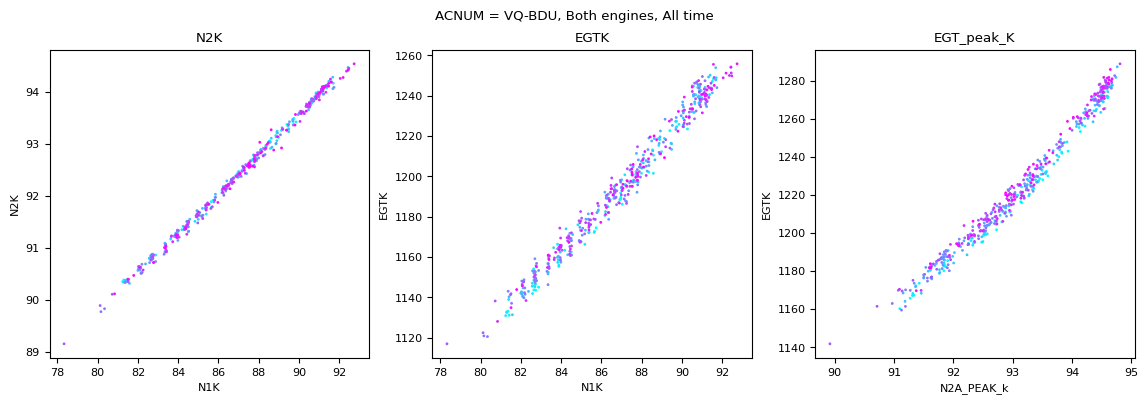

In [3]:

def plot_baselines(data, title):
  plt.rcParams.update({'font.size': 8})
  fig, axs = plt.subplots(1, 3)
  fig.set_size_inches(14, 4)
  fig.suptitle(title)
  
  cm = matplotlib.colormaps['cool']

  axs[0].scatter(data['n1ak'], data['n2ak'], s=1, c=data['reportts'], cmap=cm)
  axs[0].set(xlabel='N1K', ylabel='N2K', title="N2K")

  axs[1].scatter(data['n1ak'], data['egtk'], s=1, c=data['reportts'], cmap=cm)
  axs[1].set(xlabel='N1K', ylabel='EGTK', title="EGTK")

  axs[2].scatter(data['n2a_peak_k'], data['egt_peak_k'], s=1, c=data['reportts'], cmap=cm)
  axs[2].set(xlabel='N2A_PEAK_k', ylabel='EGTK', title="EGT_peak_K")

  return axs

data = correct(bdu)

plot_baselines(data.query('pos == 2')[:500], title='ACNUM = VQ-BDU, Both engines, All time')

In [5]:
# from sklearn.metrics import r2_score
# import numpy as np 

# acnum = 'VQ-BDU'
# pos = 1

# data = bdu.query('acnum == @acnum and pos == @pos and prv == 0')[:100].copy()

# best_r = -1000
# best_alpha = None

# for a in np.arange(0.6, 1, 0.001):
#   sub = correct(data, alpha_2=a)

#   model = train_engine_baseline(sub, 'n2a_peak_k', 'egt_peak_k', degree=1)

#   pred = model.predict(sub[['n2a_peak_k']])

#   r2 = r2_score(sub['egt_peak_k'],  pred)

#   if r2 > best_r:
#     best_r = r2
#     best_alpha = a

# best_r, best_alpha

In [6]:
x_param='n2a_peak_k'
y_param='egt_peak_k'

In [7]:
import numpy as np

data = correct(bgu, alpha_2=1).query('pos == 1')[0:500]

prv0 = data.query('prv == 0')
prv1 = data.query('prv == 1')

b_off = train_engine_baseline(prv0, x_param, y_param, degree=1)
b_on  = train_engine_baseline(prv1, x_param, y_param, degree=1)

x = np.arange(data[x_param].min(), data[x_param].max()).reshape(-1, 1)

egt_diff = (b_off.predict(x) - b_on.predict(x)).mean()

print(f"When pressure release valve is OFF, egt is greater by {egt_diff} degrees")

When pressure release valve is OFF, egt is greater by -2.8123634786666876 degrees


/home/group.s7/b.korzh/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/group.s7/b.korzh/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


/home/group.s7/b.korzh/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/group.s7/b.korzh/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


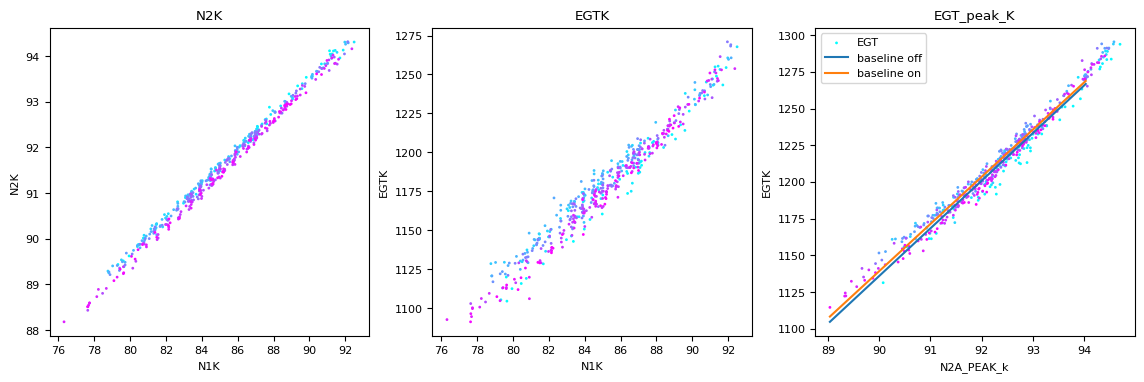

In [8]:
axs = plot_baselines(data, title='')

x = np.arange(data[x_param].min(), data[x_param].max()).reshape(-1, 1)

axs[2].plot(x, b_off.predict(x))
axs[2].plot(x, b_on.predict(x))

axs[2].legend(["EGT", "baseline off", "baseline on"])

plt.show()

alpha2(n1, ...) 

bleed + nai + wai ... 

corner point approx 35 deg


In [12]:
# import altair as alt

# alt.Chart(data.copy(), width=900, height=400) \
#   .mark_point() \
#   .encode(
#       x=alt.X(x_param, title=""),
#       y=alt.Y(y_param, title="", scale=alt.Scale(zero=False)),
#       color=alt.Color('reportts'), 
#   )